In [101]:
# Include Section

import re
import math
import datetime
import pandas as pd
import requests
import selenium
import numpy as np
from bs4 import BeautifulSoup
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [102]:
base_url = "https://www.discogs.com"
header =  {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
NUMBER_OF_PAGES = 500

<h1>Crawling Section</h1>
<hr>

<h3>Summery</h3>
    
In this section I will collect my data from website which called 'Discogs'.
    
Discogs is a platorm for music discovery and collection.
    
for each vynil i would like to collect the next data:
'Name', 'Artist', 'Label', 'Country', 'Released Year',
'Genre', 'Tracks Num', 'Media Condition', 'Sleeve Condition',
'Seller Rating', 'For Sale', 'Have', 'Want', 'Price'.
    
In this section we can see 3 function which work hirrarchly in this order:
crawling -> song_analyze -> expand_df    
<hr>

<b>Vynil Analyze</b>

This function enter to vynil (as product) in the marketplace and collect the next data: Name', 'Artist', 'Label', 'Country', 'Released Year', 'Genre', 'Tracks Num', 'Media Condition', 'Sleeve Condition', 'Seller Rating', 'Price'.

<p>Input: vynil url (str)</p>
<p>Output: vynil data (dict)</p>

In [103]:
def vynil_analyze(url):
    
    vynil_info = {"Name": np.nan, "Artist": np.nan, "Label": np.nan,
                "Country": np.nan, "Released": np.nan, "Genre": np.nan,
                "NTracks": np.nan, "Media Condition": np.nan, "Sleeve Condition": np.nan, "Seller Rating": np.nan,
                "Price": np.nan}
    
    response = requests.get(url, headers=header)
    
    if response.ok == False:
        for_sale.append(np.nan)
        return song_info
    
    html = response.content.decode('utf-8')
    bs = BeautifulSoup(html, 'html.parser')
    
    try:
        minor = bs.find('div', attrs={'class':'profile'})
    except:
        print("DEBUG ---> Crawling ---> Can't find profile div")
        return vynil_info
    
    else:
        try:
            temp = minor.find('h1', attrs={'id':'profile_title'})
            #temp = temp.findAll('span')
            vynil_info['Name'] = temp.text.strip()
            """try:
                vynil_info['Artist'] = temp[-2].text.strip()
            except:
                print("DEBUG ---> Crawling ---> Can't find artist")"""
        except:
            print("DEBUG ---> Crawling ---> Can't find h1")
            
            
        # Section for finding Label, Country, Released-Year and Genre
        try:
            heads = minor.findAll('div', attrs={'class':'head'})
            contents = minor.findAll('div', attrs={'class':'content'})
        except:
            print("DEBUG ---> Crawling ---> Can't find h1")
        else:
            for i in range(len(heads)):
                    
                try:
                    current = heads[i].text.strip(':')
                except:
                    print("DEBUG ---> vynil ---> Can't find headers")
                    break
                
                if current == 'Label':
                    try:
                        vynil_info['Label'] = contents[i].text.split("\u200e–")[0].strip()
                    except:
                        print("DEBUG ---> vynil ---> Can't find Label")
                    
                elif current == 'Country':
                    try:
                        vynil_info['Country'] = contents[i].text.strip()
                    except:
                        print("DEBUG ---> vynil ---> Can't find Country")
                    
                elif current == 'Released':
                    try:
                        vynil_info['Released'] = contents[i].text.strip()
                    except:
                        print("DEBUG ---> vynil ---> Can't find RYear")
                        vynil_info['Released'] = np.nan
                    
                elif current == 'Genre':
                    try:
                        vynil_info['Genre'] = contents[i].text.strip()
                    except:
                        print("DEBUG ---> vynil ---> Can't find Genre")
        # End section
        
        
        # Tracks Number of the vynil
        try:
            minor = bs.find('table', attrs={'class':'playlist'})
            vynil_info['NTracks'] = len(minor.findAll('tr')) - 1 # -1 Because table unrelevant property
        except:
            print("DEBUG ---> vynil ---> Can't find tracks table")
        
        try:
            minor = bs.find('div', attrs={'id': 'page_aside'})
            temp = minor.findAll('div', attrs={'class': 'section_content'})
        except:
            print("DEBUG ---> vynil ---> Cant find page side")
        
        else:
            try:
                current = temp[0].find('span', attrs={'class': 'price'})
                vynil_info['Price'] = current.text.strip('$')
            except:
                print("DEBUG ---> vynil ---> Cant find the price")
            
            try:
                current = temp[1].findAll('p')
                pattern = r"\((.*?)\)"
                vynil_info['Media Condition'] = re.search(pattern, current[0].text).group(1)
                vynil_info['Sleeve Condition'] = re.search(pattern, current[1].text).group(1)
            except:
                print("DEBUG ---> vynil ---> Cant find vynil condition")
            
            try:
                vynil_info['Seller Rating'] = temp[2].strong.text.strip('%')
            except:
                print("DEBUG ---> vynil ---> Cant find seller rating")
        
        
    print(f"DEBUG ---> vynil ---> Done with vynil_analyze")
    print(vynil_info)
    
    return vynil_info

<hr>
<b>Expand Df</b>

This function enter to vynil (as release) in the archive and collect the next data: Name', 'For Sale', 'Have', 'Want'.

<p>Input: vynil name (str)</p>
<p>Output: vynil data (dict)</p>

In [104]:
def expand_df(vynil):
    
    i = 0
    
    song_info = {"For Sale": np.nan, "Have": np.nan, "Want": np.nan}
    
    search_url = f'https://www.discogs.com/search?q={vynil}&type=all&layout=sm'

    response = requests.get(search_url, headers=header)

    if response.ok == False:
        for_sale.append(np.nan)
        return song_info

    html = response.content.decode('utf-8')
    bs = BeautifulSoup(html, 'html.parser')
    try:
        vynil_url = bs.find('a', attrs={'class': 'search_result_title'})['href']
    except:
        return song_info
        
    vynil_url = base_url + vynil_url


    print(f"DEBUG ---> Crawling ---> expand_df: enter{vynil_url}")
    response = requests.get(vynil_url, headers=header)

    if response.ok == False:
        for_sale.append(np.nan)
        return song_info

    html = response.content.decode('utf-8')
    bs = BeautifulSoup(html, 'html.parser')


    try:
        song_info['For Sale'] = bs.find('span', attrs={'class': 'forsale_QoVFl'}).a.text.split(' ')[0]
    except:
        pass
    #print(f"DEBUG ----> Crawling - expand => {vynil} = {song_info['For Sale']}") # DEBUG
        
    try:
        pattern = r"Want:\d+"
        t = re.search(pattern, bs.text)
        song_info['Want'] = t.group().split(':')[-1]
    except:
        pass
        
    try:
        pattern = r"Have:\d+"
        t = re.search(pattern, bs.text)
        song_info['Have'] = t.group(0).split(':')[-1]
        
    except:
        pass
    
    print(f"DEBUG ---> Crawling ---> Done with expand_df")
    print(song_info)
    
    return song_info
    

<hr>
<b>Crawling</b>

This is the main function of the crawling section. In this function we run N pages in Discogs marketplace and collect the relevant info for each vynil (using vynil analyze). For which vynil we collect from the marketplace we enter to the archive (using expand df) and take more statistics info.

<p>Input: None</p>
<p>Output: vynils dataframe (dict)</p>

In [105]:
def crawling():
    """
    This is the main function of the crawling section. In this function we run N pages in Discogs marketplace
    and collect the relevant info for each vynil.
    Input: None 
    Output: Vynil's dataframe
    """
    vynil_l = []
    artist = []
    label = []
    country = []
    rYear = []
    genre = []
    nTracks = []
    mCondition = []
    sCondition = []
    sellerRating = []
    price = []
    for_sale = []
    have = []
    want = []
    
    sleep_counter = 1
    try:
        for page_n in range(1,NUMBER_OF_PAGES):
            print(f"DEBUG ---> Crawling ---> page {page_n}/{NUMBER_OF_PAGES}")
            page_url = f'https://www.discogs.com/sell/list?sort=listed%2Cdesc&limit=50&currency=USD&format=Vinyl&page={page_n}'
            
            response = requests.get(page_url, headers=header)
            page_html = response.content.decode('utf-8')
            page_bs = BeautifulSoup(page_html, 'html.parser')
            
            page_vynils_list = page_bs.findAll('a', attrs={'class':'item_description_title'})
            
            for vynil in page_vynils_list:
                vynil_lnk = vynil['href']
                vynil_lnk = base_url + vynil_lnk 
                print(f"DEBUG ---> Crawling ---> enter: {vynil_lnk}")
                temp = vynil_analyze(vynil_lnk)
                vynil_l.append(temp['Name'].split('\u200e–')[-1].strip())
                artist.append(temp['Name'].split('\u200e–')[0].strip())
                label.append(temp['Label'])
                country.append(temp['Country'])
                rYear.append(temp['Released'])
                genre.append(temp['Genre'])
                nTracks.append(temp['NTracks'])
                mCondition.append(temp['Media Condition'])
                sCondition.append(temp['Sleeve Condition'])
                sellerRating.append(temp['Seller Rating'])
                price.append(temp['Price'])
                
                try:
                    temp['Name'] = temp['Name'].split('\u200e–')[-1].strip()
                    temp = expand_df(temp['Name'])
                    
                    for_sale.append(temp['For Sale'])
                    have.append(temp['Have'])
                    want.append(temp['Want'])
                except:
                    for_sale.append(np.nan)
                    have.append(np.nan)
                    want.append(np.nan)
                    pass
                
                sleep_counter+=1
                if sleep_counter == 10:
                    sleep_counter = 0
                    print(f"DEBUG ---> Crawling ---> SLEEP")
                    time.sleep(20)
                    
    except Exception as e:
        print(e)
        print(f"DEBUG ---> Crawling ---> Crashed")
        pass
        
    df = pd.DataFrame({'Vynil': vynil_l, 'Artist': artist, 'Label': label, 'Country': country, 'Released Year': rYear,
                       'Genre': genre, 'Tracks Num': nTracks, 'Media Condition': mCondition, 'Sleeve Condition': sCondition,
                       'Seller Rating': sellerRating,"For Sale": for_sale, "Have": have, "Want": want, 'Price': price})
    
    df.to_csv('vynil_db.csv')
    
    return df


===========================================

In [106]:
df = pd.read_csv('vynil_db.csv')

<h1>Organizae Data</h1>

In this section I will fill missing values, change col types to the relevant types and make all rows in specific column to be same syntax
<hr>

<p>First I would like to get rid of the unnamed columns that added automaticlly.</p>
<p>Then, I would like to drop all the rows with NaN's values in the 'Vynil', 'Price', 'For Sale', 'Have', 'Want' columns and that is because I use a lot with those cols - It's not suposed to be a lot of rows.</p>
<p>After that, I will fill the missing values in other columns with the average col value or the most frequent value. </p>

In [107]:
# Drop the unnamed columns
while df.columns[0] != 'Vynil':
    df = df.iloc[:,1:]

# Drop rows with nan values in 'Vynil' and 'Price' columns
df.dropna(subset=['Vynil', 'Price', 'For Sale', 'Have', 'Want'], inplace=True)

df['Artist'] = df['Artist'].fillna('Unknown Artist')
df['Label'] = df['Label'].fillna(df['Label'].value_counts().idxmax())

df['Country'] = df['Country'].fillna(df['Country'].value_counts().idxmax())

# Fill the Tracks Number missing values with the average value 
df['Tracks Num'] = df['Tracks Num'].fillna(round(df['Tracks Num'].mean()))

# Fill the media/sleeve condition missing values with the most frequent value
df['Media Condition'] = df['Media Condition'].fillna(df['Media Condition'].value_counts().idxmax())

df['Sleeve Condition'] = df['Sleeve Condition'].fillna(df['Sleeve Condition'].value_counts().idxmax())

Set the Released Year col to be just year [25 Jun 2021, Jun 2021, 2021] - and fill missing values with most frquent value

In [108]:
df['Released Year'] = df['Released Year'].fillna('##') # NaN's type is float and use '##' as walk-around before use split
df['Released Year'] = df.apply(lambda row: row['Released Year'].split(' ')[-1], axis=1)
df['Released Year'].replace('##', np.nan, inplace=True)
df['Released Year'] = df['Released Year'].fillna(df['Released Year'].value_counts().idxmax())
df['Released Year'] = df['Released Year'].astype('int')
df['Released Year'] = df.apply(lambda row: round(row['Released Year']/10)*10, axis=1)

Every Genre cell include many genres that the vynil can be related to. So I took the first genre that showed and set it to be the 'main' vynil genre

In [109]:
df['Genre'] = df['Genre'].fillna(df['Genre'].value_counts().idxmax())

def simplify_genre(row):
        genre = row['Genre'].split(',')
        res = [g.strip() for g in genre]
        
        return str(res[0])
    
df['Genre'] = df.apply(lambda row: simplify_genre(row), axis=1)

Sometimes there wasn't a seller rating in the marketplace and my code collect irrelevant data which showed at the same div.
In the next cell I tried to figure out if the cell value is text or number and if its text - replace with nans and fill it with the most frequent value.

In [110]:
# Change all the values in the column who's not float to NaN
df['Seller Rating'] = df.apply(lambda row: float(row['Seller Rating']) if row['Seller Rating'][0].isdigit() else np.nan, axis=1)
df['Seller Rating'] = df['Seller Rating'].astype('float')
df['Seller Rating'] = df['Seller Rating'].fillna(round(df['Seller Rating'].mean()))
df['Seller Rating'] = df.apply(lambda row: int(row['Seller Rating']), axis=1)

Set the 'Price', 'Have', 'Want' cols to float/int type

In [111]:
df['Price'] = df.apply(lambda row: float(row['Price'].replace(',', '')), axis=1)

df['Want'] = df['Want'].astype('int')
df['Have'] = df['Have'].astype('int')

In [112]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

<h1>Graphs</h1>
<hr>

In this section I built graphs to find and see the segemetation of specific columns to find out how to make my data easier to train & test. 
<p> First I started with the basic columns that make sense (for me) that they affect on the price </p>

<AxesSubplot:title={'center':'Country'}, ylabel='Country'>

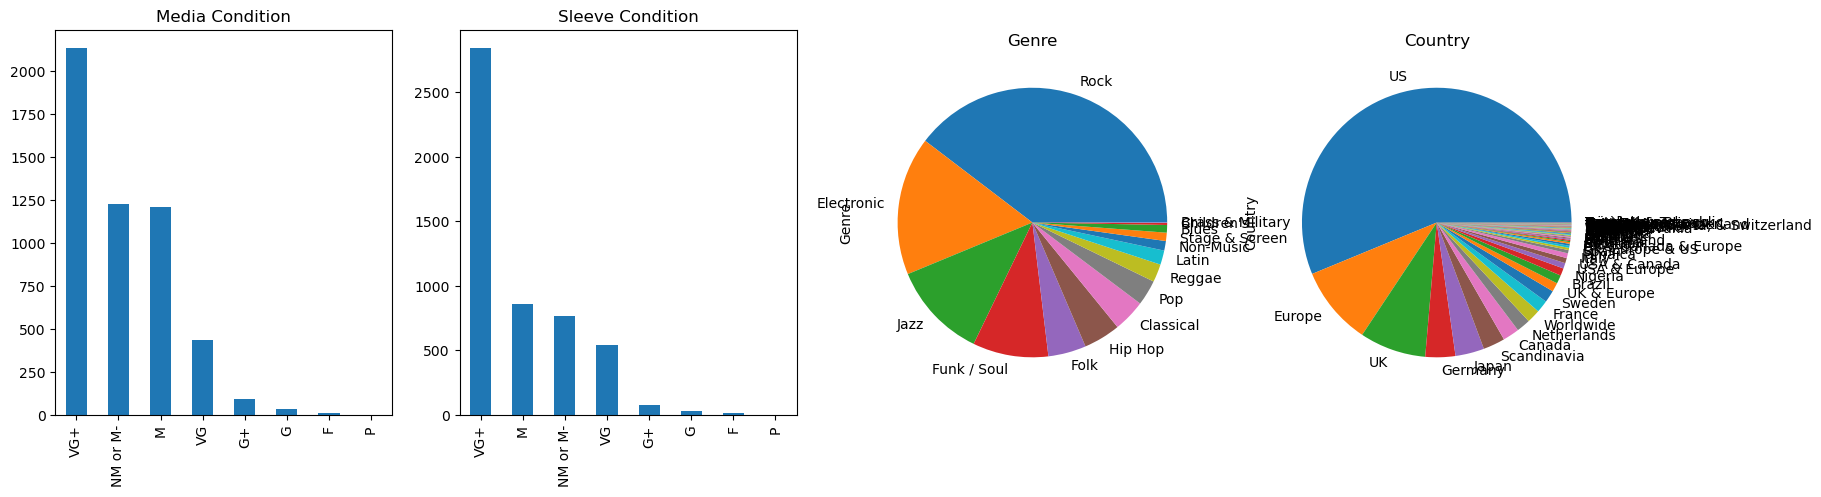

In [113]:
fig, axes = plt.subplots(1,4, figsize=(20,5))

series = df['Media Condition'].value_counts()
axes[0].set_title('Media Condition')
series.plot(kind='bar', ax=axes[0])

series = df['Sleeve Condition'].value_counts()
axes[1].set_title('Sleeve Condition')
series.plot(kind='bar', ax=axes[1])

series = df['Genre'].value_counts()
axes[2].set_title('Genre')
series.plot(kind='pie', ax=axes[2])

series = df['Country'].value_counts()
axes[3].set_title('Country')
series.plot(kind='pie', ax=axes[3])

We can see that the country col is very messy and I need to handle it (To be continue)
<hr>

In this section I would like to see the distribution of the vynil price by bins (because the price col is numeric col) and the corrolation between the released year (by decade) and the binned price

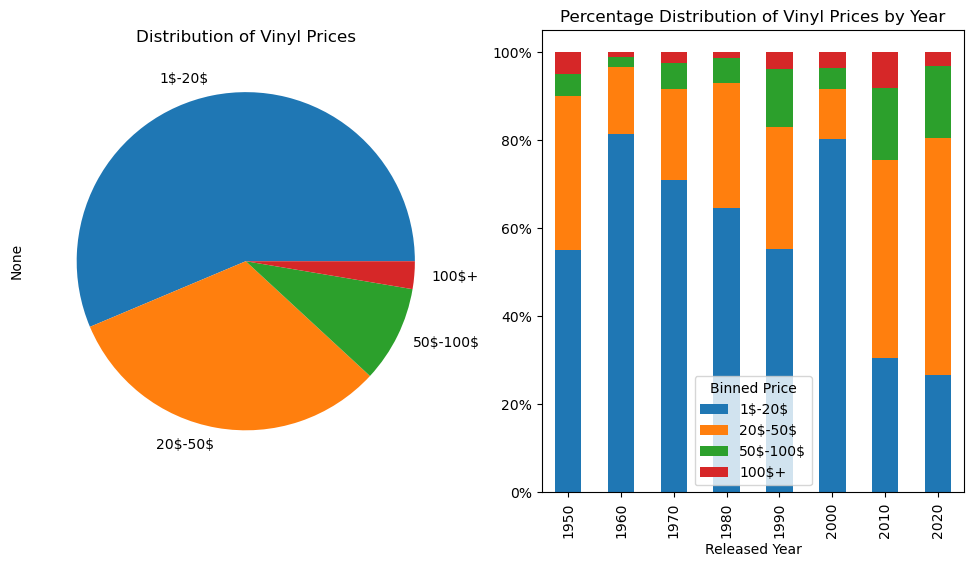

In [114]:
my_labels = ["1\$-20\$", "20\$-50\$", "50\$-100\$", "100$+"]
df['Binned Price'] = pd.cut(df['Price'], bins=[0, 20, 50, 100, 9999999], labels=my_labels)

# Create a Figure object with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph on axes[0]
df.groupby('Binned Price').size().plot(kind='pie', ax=axes[0])
axes[0].legend(title="Value Range", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
axes[0].set_title("Distribution of Vinyl Prices")

# Plot the second graph on axes[1]
df.groupby(['Released Year', 'Binned Price']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True, ax=axes[1])
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].set_title("Percentage Distribution of Vinyl Prices by Year")

# Display the figure
plt.show()

<h1>Prepares for predictions</h1>

In this section I would like to make the last preparations before I start the prediction. I add columns that use the existed columns to help the models find any constancy. 

<p>
After we look in the graph above we can see that there is too many countries that the vynil published in, so, to deal with it i created dummy's cols (manually - not with the get dummies method) that include the 3 most frequent countries or others.
</p>
<p>
Moreover, I split the media / sleeve condition to good or not good condition (for each col) and make an general 'vynil condition' that use logical or gate between media and sleeve condition. </p>

<p>After I done this i make the genre col to categorical col and drop the irrelevant cols to the prediciton. </p>

In [115]:
df['Demand'] = df['Want'] > df['For Sale'] 

df['Rare'] = df['Want'] > df['Have']

df['Expensive'] = df['Price'] > 60
df['US'] = df['Country'].str.contains('US')
df['UK'] = df['Country'].str.contains('UK')
df['Europe'] = df['Country'].str.contains('Europe')
df['Other'] = (df['US'] == False) & (df['UK'] == False)

df['Media Good Condition'] = df['Media Condition'].isin(['VG+', 'VG', 'G+', 'G'])
df['Sleeve Good Condition'] = df['Media Condition'].isin(['VG+', 'VG', 'G+', 'G'])

df['Vynil Condition'] = df['Media Good Condition'] | df['Sleeve Good Condition']


In [116]:
le = preprocessing.LabelEncoder()

df['Genre'] = le.fit_transform(df['Genre'])

In [117]:
test_df = df.drop(labels=['Vynil', 'Artist', 'Label', 'Media Condition', 'Sleeve Condition', 'Country', 'Binned Price'], axis=1)

-----------------------------------------

<h1>Predict</h1>

I created two functions of models for prediction:

Linear regression – a model we learned about in the course.
KNeighborsRegressor – a model that works in a similar way to the KNN model that we learned about in the course. It is intended for continuous variables.
In both models I used ‘Standart Scaler’.

<p> both models are pretty much defaultive and i didn't do anything special. </p>

In [118]:
def linear_regressor_get_score(df):

    columns = df.columns[df.columns != 'Price']
    columns

    X_df = df[columns]
    Y_label = df['Price']

    X_train, X_test, y_train, y_test = train_test_split(X_df, Y_label, test_size=0.33, random_state=42)


    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train, y_train)
    scaled_X_test = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(scaled_X_train, y_train)
    lr.predict(scaled_X_test)

    print("DEBUG ---> linear_get_score ---> Linear Regression Train Score:", lr.score(scaled_X_train, y_train))
    print("DEBUG ---> linear_get_score ---> Linear Regression Test Score:",lr.score(scaled_X_test,y_test))

In [119]:
def KNN_regressor_get_score(df):

    df_knn=df.copy()
    X=df_knn.drop(['Price'],axis=1)
    y=df_knn['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    rmse_val = [] 
    score_train = []
    score_test = []
    for K in range(1,20):
        model = KNeighborsRegressor(n_neighbors = K)

        model.fit(X_train, y_train) 
        pred=model.predict(X_test) 
        error = np.sqrt(metrics.mean_squared_error(y_test,pred)) 
        rmse_val.append(error)
        score_train.append(model.score(X_train,y_train))
        score_test.append(model.score(X_test,y_test))
    print("DEBUG ---> knn_get_score ---> rmse: ",min(rmse_val))
    k_best_ind=rmse_val.index(min(rmse_val))

    print("DEBUG ---> knn_get_score ---> KNN Regression Train Score:",score_train[k_best_ind])
    print("DEBUG ---> knn_get_score ---> KNN Regression Test Score:",score_test[k_best_ind])

In [120]:
linear_regressor_get_score(test_df)
KNN_regressor_get_score(test_df)

DEBUG ---> linear_get_score ---> Linear Regression Train Score: 0.3461511420141964
DEBUG ---> linear_get_score ---> Linear Regression Test Score: 0.6252073403107357
DEBUG ---> knn_get_score ---> rmse:  28.734982829843013
DEBUG ---> knn_get_score ---> KNN Regression Train Score: 0.4702164720592701
DEBUG ---> knn_get_score ---> KNN Regression Test Score: 0.5651169323846118


<h1> Conclusion </h1>
<hr>
<p>
I can see that the results of the two models are about 7 score-unit different. As we learned in the course, a result of over 50% success in the machine learning is considered successful. So therefore, we can assumed that we can predict the vynil price using the data we collected. 
</p>
<p>
However, there is something i can't still figure out and that's why there is a very big differnce and even negetiveily between the train and test score.
</p>

<h1>Notes:</h1>
<ul>
<li>As I said, my crawling source was the website - Discogs</li>
<li>For error's, I used Stack-Overflow and chat-gpt (there is'nt any function here which I took from any source)</li>
<li>The data which I use here it's save as vynil_db.csv that i get from earlier night crawling</li>
</ul>